# Incidence de la varicelle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests
import isoweek

Les données de l'incidence de la varicelle sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1991 et se termine avec une semaine récente.

In [2]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-3.csv"

Voici l'explication des colonnes données [sur le site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Nom de colonne | Libellé de colonne                                                                                                                |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| week           | Semaine calendaire (ISO 8601)                                                                                                     |
| indicator      | Code de l'indicateur de surveillance                                                                                              |
| inc            | Estimation de l'incidence de consultations en nombre de cas                                                                       |
| inc_low        | Estimation de la borne inférieure de l'IC95% du nombre de cas de consultation                                                     |
| inc_up         | Estimation de la borne supérieure de l'IC95% du nombre de cas de consultation                                                     |
| inc100         | Estimation du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants)                                   |
| inc100_low     | Estimation de la borne inférieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| inc100_up      | Estimation de la borne supérieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| geo_insee      | Code de la zone géographique concernée (Code INSEE) http://www.insee.fr/fr/methodes/nomenclatures/cog/                            |
| geo_name       | Libellé de la zone géographique (ce libellé peut être modifié sans préavis)                                                       |

La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant `skiprows=1`.

In [3]:
raw_data = pd.read_csv(data_url, skiprows=1)
raw_data

week  indicator     inc   inc_low    inc_up inc100  inc100_low  \
0     202504          3  375118  356288.0  393948.0    560       532.0   
1     202503          3  253215  239337.0  267093.0    378       357.0   
2     202502          3  257247  242991.0  271503.0    384       363.0   
3     202501          3  231549  214627.0  248471.0    345       320.0   
4     202452          3  201726  185870.0  217582.0    302       278.0   
...      ...        ...     ...       ...       ...    ...         ...   
2095  198448          3   78620   60634.0   96606.0    143       110.0   
2096  198447          3   72029   54274.0   89784.0    131        99.0   
2097  198446          3   87330   67686.0  106974.0    159       123.0   
2098  198445          3  135223  101414.0  169032.0    246       184.0   
2099  198444          3   68422   20056.0  116788.0    125        37.0   

      inc100_up geo_insee geo_name  
0         588.0        FR   France  
1         399.0        FR   France  
2         405.0        FR   France  
3         370.0        FR   France  
4         326.0        FR   France  
...         ...       ...      ...  
2095      176.0        FR   France  
2096      163.0        FR   France  
2097      195.0        FR   France  
2098      308.0        FR   France  
2099      213.0        FR   France  

[2100 rows x 10 columns]

Modification du code pour utiliser le fichier local contenant les données :
1. Vérifie si une copie locale des données existe déjà
2. Si elle n'existe pas, télécharge les données depuis le Réseau Sentinelles

In [10]:
file_path = r"C:\Users\33612\Downloads\inc-7-PAY.csv"

if not os.path.exists(file_path):
    response = requests.get(data_url)
    with open(file_path, "wb") as file:
        file.write(response.content)
    print("Téléchargement des données et sauvegarde locale.")
else:
    print("Données locales déjà existantes.")

raw_data = pd.read_csv(file_path, encoding = 'iso-8859-1', skiprows=1)
raw_data

Données locales déjà existantes.


week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202504          7   8673     5508   11838      13           8   
1     202503          7   2471     1167    3775       4           2   
2     202502          7   5966     2757    9175       9           4   
3     202501          7   6059     2451    9667       9           4   
4     202452          7   4356     1776    6936       7           3   
...      ...        ...    ...      ...     ...     ...         ...   
1777  199101          7  15565    10271   20859      27          18   
1778  199052          7  19375    13295   25455      34          23   
1779  199051          7  19080    13807   24353      34          25   
1780  199050          7  11079     6660   15498      20          12   
1781  199049          7   1143        0    2610       2           0   

      inc100_up geo_insee geo_name  
0            18        FR   France  
1             6        FR   France  
2            14        FR   France  
3            14        FR   France  
4            11        FR   France  
...         ...       ...      ...  
1777         36        FR   France  
1778         45        FR   France  
1779         43        FR   France  
1780         28        FR   France  
1781          5        FR   France  

[1782 rows x 10 columns]

Y a-t-il des points manquants dans ce jeux de données ? Non.

In [11]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Pas besoin de modifier les données comme dans le cas du syndrome grippal.

In [28]:
data = raw_data

Nos données utilisent une convention inhabituelle: le numéro de
semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.
  
Un deuxième problème est que Pandas ne comprend pas les numéros de
semaine.  Il faut lui fournir les dates de début et de fin de
semaine. Nous utilisons pour cela la bibliothèque `isoweek`.

Comme la conversion des semaines est devenu assez complexe, nous
écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont
dans une nouvelle colonne 'period'.

In [29]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans
le sens chronologique.

In [30]:
sorted_data = data.set_index('period').sort_index()

Nous vérifions la cohérence des données. Entre la fin d'une période et
le début de la période qui suit, la différence temporelle doit être
zéro, ou au moins très faible. Nous laissons une "marge d'erreur"
d'une seconde.

Ceci s'avère tout à fait juste sauf pour deux périodes consécutives
entre lesquelles il manque une semaine.

Nous reconnaissons ces dates: c'est la semaine sans observations
que nous avions supprimées !

In [31]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Un premier regard sur les données !

<Axes: xlabel='period'>

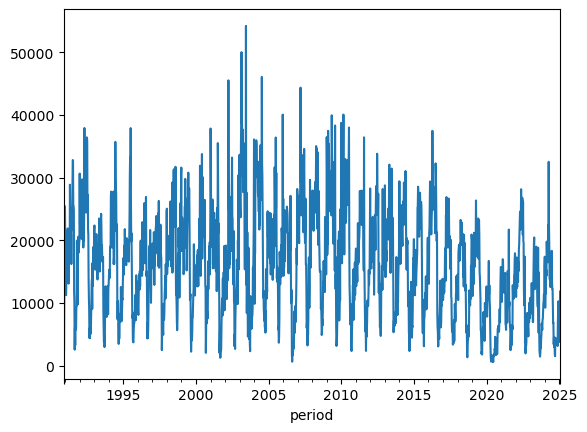

In [38]:
sorted_data['inc_up'].plot()

Un zoom sur les dernières années montre mieux la situation des pics en hiver. Le creux des incidences se trouve en été.

<Axes: xlabel='period'>

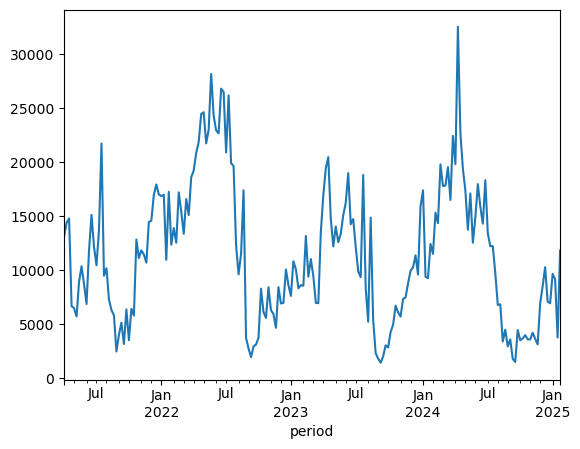

In [39]:
sorted_data['inc_up'][-200:].plot()

## Etude de l'incidence annuelle

Etant donné que le pic de l'épidémie se situe en hiver, à cheval
entre deux années civiles, nous définissons la période de référence
entre deux minima de l'incidence, du 1er août de l'année $N$ au
1er août de l'année $N+1$.

Notre tâche est un peu compliquée par le fait que l'année ne comporte
pas un nombre entier de semaines. Nous modifions donc un peu nos périodes
de référence: à la place du 1er août de chaque année, nous utilisons le
premier jour de la semaine qui contient le 1er août.

Comme l'incidence de syndrome grippal est très faible en été, cette
modification ne risque pas de fausser nos conclusions.

Encore un petit détail: les données commencent an octobre 1984, ce qui
rend la première année incomplète. Nous commençons donc l'analyse en 1985.

In [40]:
 first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er août, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [41]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc_up'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Voici les incidences annuelles.

<Axes: >

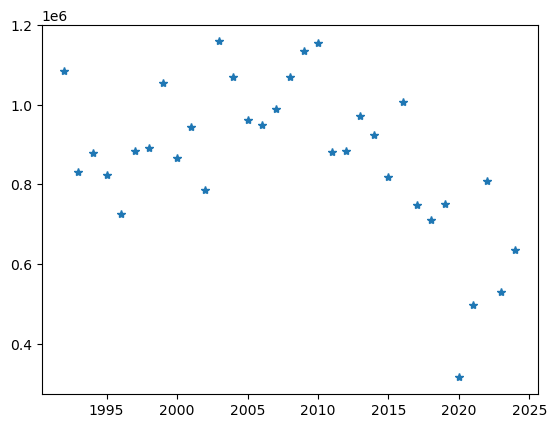

In [42]:
yearly_incidence.plot(style='*')

Une liste triée permet de plus facilement répérer les valeurs les plus élevées (à la fin).

In [43]:
yearly_incidence.sort_values()

2020     315551
2021     498218
2023     529684
2024     635489
2018     711241
1996     726373
2017     748586
2019     750000
2002     785909
2022     808973
2015     818594
1995     823747
1993     830385
2000     866282
1994     880108
2011     881779
2012     884146
1997     884271
1998     892351
2014     924636
2001     945023
2006     949742
2005     962511
2013     972671
2007     988668
2016    1008333
1999    1055734
2004    1069991
2008    1070668
1992    1084008
2009    1135565
2010    1155636
2003    1159039
dtype: int64

<Axes: >

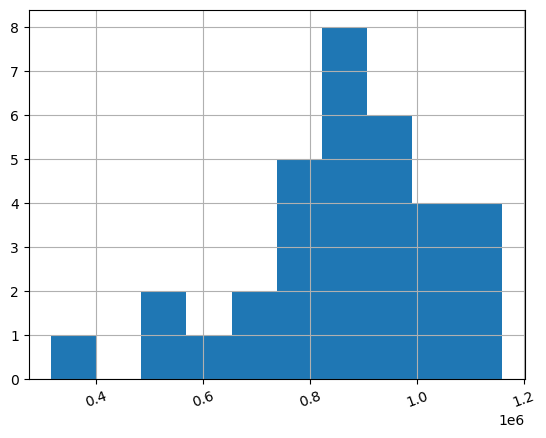

In [27]:
yearly_incidence.hist(xrot=20)